# Task 2
#### In this question you will implement and compare the following different KNN variants:
- ##### LSH
- ##### KD-Tree
- ##### Naive Version of KNN
Vary dataset size `N`, number of dimensions `D` to do training and testing time and memory comparison for finding K nearest neighbours. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage

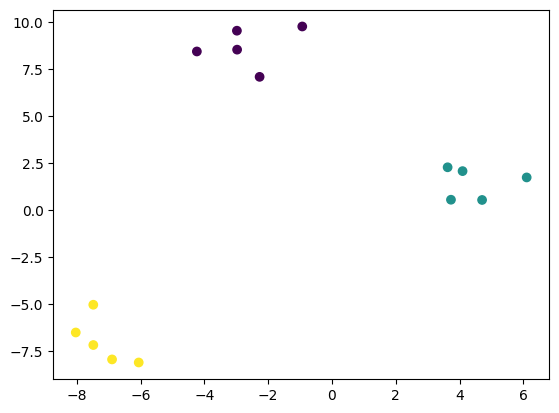

In [ ]:
n_features = 2

def generate_data(N, D, clusters=3):
    X, y = make_blobs(n_samples=N, centers=clusters, n_features=n_features, random_state=42)
    return X, y

def plot_data(matrix, labels):
    X = matrix[:, 0]
    Y = matrix[:, 1]
    plt.scatter(X, Y, c=labels)

rng = np.random.default_rng(0)

data, clusters = generate_data(N = 15, clusters=3, D=n_features)  # testing the function
plot_data(data, clusters)

### LSH 
Locality-sensitive hashing (LSH) is a method that hashes similar data points to have a high chance of being grouped together. This makes LSH a good way to optimize similarity search: by comparing the query data only with a subset of presumably similar items, you can avoid having to sort the entire dataset by some distance metric. The trade-off here is that there is no guarantee for correctness.

In [ ]:
def generate_hyperplanes(n, num_planes):
    H = rng.normal(size=(num_planes, n))  # hyperplanes as their normal vectors
    return H

planes = generate_hyperplanes(n_features, 3)